In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 9) # (w, h)
import pandas as pd
from dataclasses import dataclass

In [2]:
def parse_address(addr: str) -> int:
    if len(addr) == 17:
        return (int(addr[0:8], 16) << 32) + int(addr[9:17], 16)
    elif len(addr) == 8:
        return int(addr, 16)
    raise ValueError(f"Weird addr: '{addr}'")

@dataclass
class TraceData:
    reads_from_sys: pd.DataFrame
    writes_from_sys: pd.DataFrame
    reads_from_periphs: pd.DataFrame
    writes_from_periphs: pd.DataFrame

def sanitize_dataframe(data) -> pd.DataFrame:
    df = data.copy()
    df["Address"] = df["Address"].apply(parse_address)
    # "Length" is in dwords = 32 bits i.e. 4 bytes
    df["LengthBytes"] = df["Length"].astype("int64") * 4
    del df["Length"]
    return df

def load_relevant_pkt_data(path: str) -> TraceData:
    base_df = pd.read_csv(path, sep=',', usecols=["Link Dir", "TLP Type", "RequesterID", "Address", "Length"], dtype={"Link Dir": pd.StringDtype(), "TLP Type": pd.StringDtype(), "RequesterID": pd.StringDtype(), "Address": pd.StringDtype(), "Length": 'Int64'})

    reads = base_df.loc[base_df["TLP Type"].str.startswith("MRd")]
    writes = base_df.loc[base_df["TLP Type"].str.startswith("MWr")]

    return TraceData(
        reads_from_sys=sanitize_dataframe(reads.loc[reads["Link Dir"] == "Downstream"]),
        writes_from_sys=sanitize_dataframe(writes.loc[writes["Link Dir"] == "Downstream"]),
        reads_from_periphs=sanitize_dataframe(reads.loc[reads["Link Dir"] == "Upstream"]),
        writes_from_periphs=sanitize_dataframe(writes.loc[writes["Link Dir"] == "Upstream"]),
    )


In [3]:
trace_data_edge_login = load_relevant_pkt_data("./pcie_traces/rx460-win10-memonly3-login-edge-photos.csv") # 423.0MiB
trace_data_static_firedemo = load_relevant_pkt_data("./pcie_traces/rx460-win10-memonly3c-ffxv-firedemo-static2.csv") # 3.3GiB
trace_data_loading_firedemo = load_relevant_pkt_data("./pcie_traces/rx460-win10-memonly3b-ffxv-menu-to-firedemo.csv") # 4.4MiB

In [4]:
def lsb_of(x):
    """Returns the index, counting from 0, of the
    least significant set bit in `x`.
    """
    return (x&-x).bit_length()-1
def msb_of(x):
    """Returns the index, counting from 0, of the
    most significant set bit in `x`.
    """
    return x.bit_length() - 1

def contiguous_ranges_of(df):
    # Find all unique groups of address/length - sometimes the same address is used with multiple lengths, in that case take the largest
    pkt_ranges = df.groupby(["Address"])["LengthBytes"].max().reset_index()
    # Create an addressend 
    pkt_ranges["AddressEnd"] = pkt_ranges["Address"] + pkt_ranges["LengthBytes"]
    
    # https://stackoverflow.com/a/52245521
    # Make a series of the differences between adjacent addressEnd and addressStart values
    pkt_range_step = pkt_ranges["Address"].values[1:] - pkt_ranges["AddressEnd"].values[:-1]
    # Make a series in numpy which is 0 if the difference between previous end-start > 0, otherwise is 1
    # i.e. is 1 if this row starts a new connection
    is_new_range = np.insert(pkt_range_step > 0, 0, 1)
    pkt_ranges["range_id"] = is_new_range.cumsum()

    # Create a new dataframe from the range starts and ends
    start = pkt_ranges.groupby("range_id")["Address"].min().reset_index()
    end = pkt_ranges.groupby("range_id")["AddressEnd"].max().reset_index()
    contig_ranges = start
    contig_ranges["LengthBytes"] = end["AddressEnd"] - contig_ranges["Address"]

    # Convenience columns - the least and most significant bits of the address and length
    contig_ranges["AddrLowBit"] = contig_ranges["Address"].apply(lsb_of)
    contig_ranges["AddrTopBit"] = contig_ranges["Address"].apply(msb_of)
    
    contig_ranges["LengthLowBit"] = contig_ranges["LengthBytes"].apply(lsb_of)
    contig_ranges["LengthTopBit"] = contig_ranges["LengthBytes"].apply(msb_of)
    contig_ranges["LengthMantissa"] = contig_ranges["LengthBytes"].apply(msb_of) - contig_ranges["LengthBytes"].apply(lsb_of)

    return contig_ranges

,Link Dir,TLP Type,RequesterID,Address,LengthBytes
126,Upstream,MRd(32),023:00:0,1679488000,64
127,Upstream,MRd(32),023:00:0,1679488064,64
128,Upstream,MRd(32),023:00:0,1679488128,64
129,Upstream,MRd(32),023:00:0,1679488192,64
130,Upstream,MRd(32),023:00:0,1679488320,64
...,...,...,...,...,...
3345440,Upstream,MRd(32),023:00:0,14381056,256
3345441,Upstream,MRd(32),023:00:0,14381312,256
3345443,Upstream,MRd(32),023:00:0,14381568,256
3345448,Upstream,MRd(32),023:00:0,1684709376,32


Per-packet transaction lengths


,LengthBytes,0
0,32,40794
1,64,2385755
2,96,13
3,128,13
4,160,159
5,192,19
6,224,8
7,256,104084


Contiguous ranges


,Address,LengthBytes
0,12718080,8192
1,12730368,7936
2,13565952,65536
3,13643776,77824
4,13766656,12288
...,...,...
11637,137828958208,4096
11638,137830895616,704
11639,137830896384,1216
11640,137830897664,1216


Contiguous range lengths
6


,LengthBytes,0,LengthMarginFor6.3FP
0,32,21,0.0
1,64,1112,0.0
2,96,1,0.0
3,128,163,0.0
4,192,331,0.0
5,224,64,0.0
6,256,207,0.0
7,320,298,0.0
8,384,15,0.0
9,448,2391,0.0


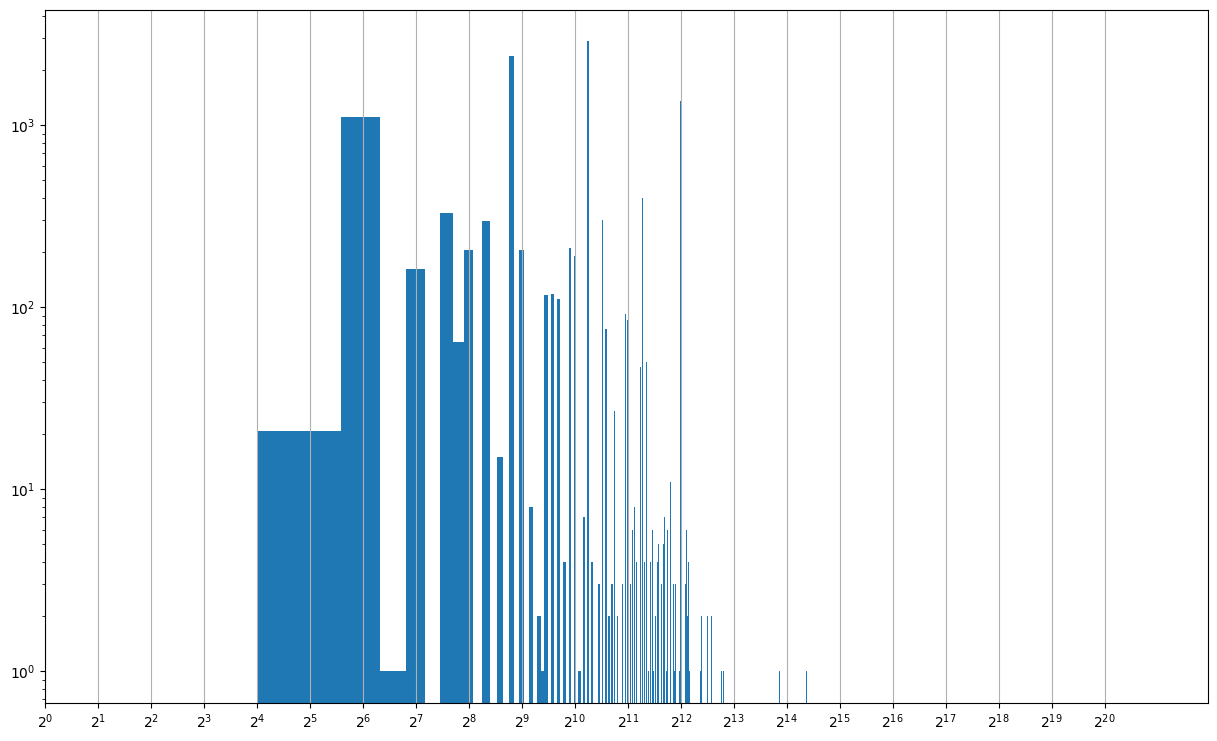

Required address bit range


,MSB,LSB,length
0,37,6,32


Length maximum mantissa, i.e. min low bit


,LengthTopBit,LengthLowBit,Mantissa,Summary
0,5,5,0,0x20 + 0x20
1,6,5,1,0x40 + 0x20
2,7,5,2,0x80 + 0x20
3,8,6,2,0x100 + 0x40
4,9,5,4,0x200 + 0x20
5,10,6,4,0x400 + 0x40
6,11,6,5,0x800 + 0x40
7,12,6,6,0x1000 + 0x40
8,13,6,7,0x2000 + 0x40
9,14,6,8,0x4000 + 0x40


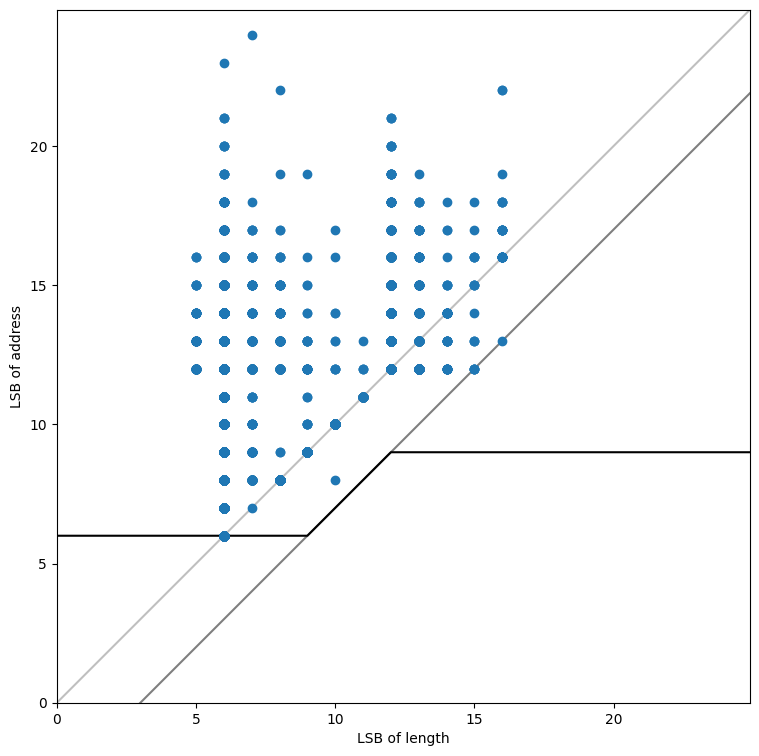

Maximum fixed-base-floating-length format required to perfectly represent these ranges:
Length:  6.12	floating
Address: 31.3	fixed
Total:   52
Max representable 4KiB address: 0x0000080000000000
Top settable bit of 4KiB range: 43


In [5]:
# Choose data to analyse
# trace_data_edge_login.writes_from_sys is the most challenging - presumably this is because you have to load a lot of images onto the gpu.
# zero trace_data_edge_login.reads_from_sys
# trace_data_static_firedemo and trace_data_loading_firedemo don't have a lot of activity anywhere - mostly reads/writes to configs and mailboxes? not a lot of loading

# data = trace_data_edge_login.writes_from_sys
data = trace_data_edge_login.reads_from_periphs
# data = trace_data_static_firedemo.writes_from_sys
display(data)

print("Per-packet transaction lengths")
display(data.groupby(["LengthBytes"]).size().reset_index())

contig_ranges = contiguous_ranges_of(data)

print("Contiguous ranges")
display(contig_ranges[["Address", "LengthBytes"]])

print("Contiguous range lengths")
print(msb_of(64))
def min_length_6_3_containing(x):
    e = msb_of(x)
    l = 2 ** e
    if l == x:
        return l
    for m in range(8):
        if l * (1 + m/8) >= x:
            return l * (1 + m/8)
    return 2 * l
def margin_on_length_6_3(x):
    return min_length_6_3_containing(x) - x
contig_ranges_by_length = contig_ranges.groupby(["LengthBytes"]).size().reset_index()
contig_ranges_by_length["LengthMarginFor6.3FP"] = contig_ranges_by_length["LengthBytes"].apply(margin_on_length_6_3)
with pd.option_context('display.max_rows', 200, 'display.max_columns', 10):
    display(contig_ranges_by_length)
# TODO PLOT THIS
fig, ax = plt.subplots()
ax.bar(contig_ranges_by_length["LengthBytes"], contig_ranges_by_length[0], width=32)
# ax.set(ylim=[0, 400])
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xticks([2**n for n in range(21)])
# ax.set_xticks([(1+m/8) * 2**n for n in range(21) for m in range(8)], minor=True)
ax.grid(True, which="both", axis="x", ls="-")
plt.show()

print("Required address bit range")
addr_lsb = contig_ranges["AddrLowBit"].min()
addr_msb = contig_ranges["AddrTopBit"].max()
display(pd.DataFrame({"MSB": [addr_msb], "LSB": [addr_lsb], "length": [addr_msb - addr_lsb + 1]}))

print("Length maximum mantissa, i.e. min low bit")
length_mantissa_cmp = contig_ranges.groupby(["LengthTopBit"])["LengthLowBit"].min().reset_index()
length_mantissa_cmp["Mantissa"] = (length_mantissa_cmp["LengthTopBit"] - length_mantissa_cmp["LengthLowBit"])
length_mantissa_cmp["Summary"] = [
    f"0x{(2 ** row['LengthTopBit']):x} + 0x{2 ** row['LengthLowBit']:x}"
    for idx, row in length_mantissa_cmp.iterrows()
]
display(length_mantissa_cmp)

# Plot length LSB vs addr LSB with an x=y graph in the middle.
# Ideally for us, the addr LSB >= length LSB.
# If not, do addr LSB >= length LSB - EXTRA_BITS - EXTRA_BITS is the amount of the address bits we need in the fixed-point case
# *assuming we can represent the length perfectly* :P
EXTRA_BITS = 3 # From inspection.
fig, ax = plt.subplots()
ax.scatter(contig_ranges["LengthLowBit"], contig_ranges["AddrLowBit"])
ax.set(xlabel="LSB of length", ylabel="LSB of address")

lims = [
    0,
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, [x for x in lims], 'k-', alpha=0.25, zorder=0)
ax.plot(lims, [x-3 for x in lims], 'k-', alpha=0.5, zorder=0)
# now just for fun plot the alignment of 64=y=6bits for x=0..9bits, then 
ax.plot([0, 9, 12, max(lims)], [6, 6, 9, 9], 'k-', alpha=1.0, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

# fixed-base floating-length => length = 2**e * (1 + m/2**M) i.e. a E.M floating-point, and base = (b / (2 ** SUBLENGTH)) * (2 ** e) - i.e. a (B-SUBLENGTH).SUBLENGTH fixed-point number shifted up and down based on `e`.
# Previously, I've been thinking about E=6 (need full 64-bit range) with M=3, B=52 (so 4KiB pages where e=12 can represent the full addr range) and SUBLENGTH=3.
# The inherent problem with this is that there exists some e-values and thus some lengths which can't reach the top of the addrspace (unless B=64).
# The other thing I need to make sure is possible, is to subsequently divide all of these contiguous ranges into the 64 or 256-byte slices the individual transactions write to!
print("Maximum fixed-base-floating-length format required to perfectly represent these ranges:")
length_mantissa = length_mantissa_cmp["Mantissa"].max()
sublength_addr_bits = (contig_ranges["LengthLowBit"] - contig_ranges["AddrLowBit"]).max()
lengthmult_addr_bits = (contig_ranges["AddrTopBit"] - contig_ranges["LengthLowBit"]).max()
print(f"Length:  6.{length_mantissa}\tfloating")
print(f"Address: {lengthmult_addr_bits}.{sublength_addr_bits}\tfixed")
print(f"Total:   {6 + length_mantissa + lengthmult_addr_bits + sublength_addr_bits}")
print(f"Max representable 4KiB address: 0x{2 ** (lengthmult_addr_bits + 12):016x}")
print(f"Top settable bit of 4KiB range: {lengthmult_addr_bits + 12}") 

In [6]:
# Contiguous range analysis - we want to figure out what contiguous ranges are accessed.


print(contig_ranges)
print(contig_ranges.loc[contig_ranges["LengthMantissa"] >= 7]["LengthBytes"])
print(contig_ranges.groupby(["LengthBytes", "LengthMantissa"]).size().reset_index())

# TODO the above logic needs checking, but for now...

       range_id       Address  LengthBytes  AddrLowBit  AddrTopBit  \
0             1      12718080         8192          12          23   
1             2      12730368         7936          14          23   
2             3      13565952        65536          16          23   
3             4      13643776        77824          12          23   
4             5      13766656        12288          12          23   
...         ...           ...          ...         ...         ...   
11637     11638  137828958208         4096          16          37   
11638     11639  137830895616          704          12          37   
11639     11640  137830896384         1216           8          37   
11640     11641  137830897664         1216          11          37   
11641     11642  137830898944          768           8          37   

       LengthLowBit  LengthTopBit  LengthMantissa  
0                13            13               0  
1                 8            12               4  
2  